# Analyze the best performing models of each type

In [1]:
import importlib

# Load modules
import os
import sys
from time import time
from scipy import stats
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
# Load the help functions
import support.acc_funs
importlib.reload(support.acc_funs)
from support.acc_funs import fast_auc, fast_decomp, write_fast_decomp, write_fast_inference, gen_CI
from support.support_funs import makeifnot, decomp_var
from support.get_cpt_annotations import cpt_desciptions
from scipy.interpolate import UnivariateSpline


from scipy.stats import rankdata
from time import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Set directories
dir_base = os.getcwd()
dir_NSQIP = os.path.join(dir_base,'..')
dir_output = os.path.join(dir_NSQIP, 'output')
dir_weights = os.path.join(dir_output, 'weights')
dir_figures = os.path.join(dir_NSQIP, 'figures')
makeifnot(dir_figures)

di_model = {'logit':'Logistic-L2', 'rf':'RandomForest', 'xgb':'XGBoost', 'nnet':'MultiNet'}
di_outcome = {'adv':'ADV', 'aki':'AKI', 'cns':'CNS',
              'nsi':'nSSIs', 'ssi':'SSIs', 'unplan':'UPLN'}
di_method = {'agg':'Aggregate', 'sub':'CPT-model'}

cpt_trans = cpt_desciptions()

In [2]:
# Dummy data to make sure fast approximations line up
y = np.array([1,1,1,1,0,0,0,1])
s = np.array([6,5,7,5,3,2,2,1])
g = np.array(['a','a','b','a','b','b','b','c'])
# print(fast_auc(y,s,both=False,den=False))
print(fast_decomp(y,s,g,ret_df=False))

        tt   auc  den  n1
0    total  0.80   15   5
1   within  1.00    3   5
2  between  0.75   12   0


## (1) Load in data

In [3]:
fn_output = pd.Series(os.listdir(dir_output))
fn_best = fn_output[fn_output.str.contains('.csv$') & fn_output.str.contains('^best')].reset_index(None,True)

fn_csv = 'df_best.csv'
check_csv = fn_csv in os.listdir(dir_output)
if not check_csv:
    print('Loading data via loop')
    holder = []
    cn_keep = ['model','outcome','test_year','cpt','y','preds']
    for fn in fn_best:
        print('Loading file: %s' % fn)
        path = os.path.join(dir_output, fn)
        tmp_df = pd.read_csv(path, usecols=cn_keep)  #, nrows=10
        tmp_df.rename(columns={'model':'method'},inplace=True)
        mdl = fn.split('.')[0].split('_')[-1]
        tmp_df.insert(0,'model',mdl)
        holder.append(tmp_df)
        del tmp_df
        #break
    df_nsqip = pd.concat(holder).reset_index(None, True)
    df_nsqip.outcome = df_nsqip.outcome.str.replace('agg_','')
    df_nsqip['version'] = df_nsqip.outcome.str.replace('[^0-9]','')
    df_nsqip.version = np.where(df_nsqip.version == '', '1', df_nsqip.version).astype(int)
    df_nsqip.outcome = df_nsqip.outcome.str.replace('[^a-z]','')
    del holder
    print('Writing to file')
    df_nsqip.to_csv(os.path.join(dir_output, fn_csv), index=False)
else:
    print('Loading large CSV file')
    df_nsqip = pd.read_csv(os.path.join(dir_output, fn_csv))
df_nsqip.head(2)
dat_cpt_year = df_nsqip.groupby(['test_year','cpt']).size().reset_index().drop(columns=[0])

Loading large CSV file


In [4]:
# df_nsqip.query('model=="rf"&outcome=="adv"&version==1&method=="agg"').cpt.unique().shape

In [5]:
#df_nsqip.groupby(['model','method']).size()
# CALCULATE THE NUMBER OF CPTS IN ANY GIVEN YEAR (PLOT....)


### Get multitask model

In [6]:
# dat_X = pd.read_csv(os.path.join(dir_output,'X_imputed.csv'),usecols=['caseid','operyr','cpt'])
# dat_Y = pd.read_csv(os.path.join(dir_output,'y_agg.csv'))
# cn_agg = list(dat_Y.columns[dat_Y.columns.str.contains('agg')])
# dat_Y = dat_Y[['caseid','operyr']+cn_agg]
# dat_Y.columns = dat_Y.columns.str.replace('agg\\_','')
# dat_Y = dat_Y.query('operyr>=2014')  # No multitask results before 2014
# dat_Y = dat_Y.melt(['caseid','operyr'],None,'outcome','y')
# dat_Y['version'] = dat_Y.outcome.str.replace('[^0-9]','')
# dat_Y.version = np.where(dat_Y.version == '', '1', dat_Y.version).astype(int)
# dat_Y.outcome = dat_Y.outcome.str.replace('[^a-z]','')

# Need to subset rows to equivalent
fn_weights = pd.Series(os.listdir(dir_weights))
fn_weights = fn_weights[fn_weights.str.contains('[0-9]{4}\\.csv$')].reset_index(None, True)
holder = []
for fn in fn_weights:
    print('fn: %s' % fn)
    tmp = pd.read_csv(os.path.join(dir_weights, fn))
    tmp = tmp.drop(columns='Unnamed: 0').rename(columns={'lbl':'outcome','operyr':'test_year','phat':'preds'})
    tmp = tmp[tmp.outcome.str.contains('^agg')].reset_index(None,True)
    tmp = tmp.merge(dat_cpt_year,'inner',['test_year','cpt'])
    tmp.outcome = tmp.outcome.str.replace('agg_','')
    tmp['version'] = tmp.outcome.str.replace('[^0-9]','')
    tmp.version = np.where(tmp.version == '', '1', tmp.version).astype(int)
    tmp.outcome = tmp.outcome.str.replace('[^a-z]','')
    holder.append(tmp)
dat_multi = pd.concat(holder)
dat_multi = dat_multi.sort_values(['test_year','outcome']).reset_index(None,True)
dat_multi = dat_multi.assign(method='agg',model='nnet')
df_nsqip = pd.concat([df_nsqip, dat_multi]).reset_index(None,True)

fn: df_test_2016.csv
fn: df_test_2017.csv
fn: df_test_2018.csv
fn: df_test_2015.csv
fn: df_test_2014.csv


## (2) Decompose AUROCs within/between + CPTs (all years and no years)

In [7]:
# Decompose including the year
cn_gg1 = ['model','test_year','outcome','version','method']
fn_within_year = 'df_within_year.csv'
df_within_year = write_fast_decomp(df=df_nsqip, fn=fn_within_year, cn=cn_gg1, path=dir_output, ret_df=False)
# Repeat on the CPT level
fn_within_year_cpt = 'df_within_year_cpt.csv'
df_within_year_cpt = write_fast_decomp(df=df_nsqip, fn=fn_within_year_cpt, cn=cn_gg1, path=dir_output, ret_df=True)

# Decompose aggregating over years
cn_gg2 = ['model','outcome','version','method']
fn_within = 'df_within.csv'
df_within = write_fast_decomp(df=df_nsqip, fn=fn_within, cn=cn_gg2, path=dir_output, ret_df=False)
# Repeat on the CPT level
fn_within_cpt = 'df_within_cpt.csv'
df_within_cpt = write_fast_decomp(df=df_nsqip, fn=fn_within_cpt, cn=cn_gg2, path=dir_output, ret_df=True)

Decomposition already exists, loading: df_within_year.csv
Decomposition already exists, loading: df_within_year_cpt.csv
Decomposition already exists, loading: df_within.csv
Decomposition already exists, loading: df_within_cpt.csv


## (3) Find the "best" label and models

In [8]:
# Subset to within
sub_within = df_within.query('tt == "within" & method=="agg"').reset_index(None, True)#.drop(columns=['tt'])
gg_best = ['outcome','version','method']
best_outcome = sub_within.groupby(gg_best).auc.mean().reset_index()
best_outcome = best_outcome.sort_values(['outcome','auc'],ascending=[True,False]).groupby('outcome').head(1)
best_outcome = best_outcome.drop(columns='auc').reset_index(None,True)
best_mdl = sub_within.merge(best_outcome, 'inner', gg_best)
best_mdl = best_mdl.groupby(gg_best+['model']).apply(lambda x: np.sum(x.auc*x.den)/x.den.sum()).reset_index()
best_mdl = best_mdl.rename(columns={0:'auc'}).sort_values(['outcome','auc'],ascending=[True,False])
best_mdl = best_mdl.groupby(['outcome']).head(1).reset_index(None, True).drop(columns='auc')
print(best_outcome)
print(best_mdl)

  outcome  version method
0     adv        1    agg
1     aki        1    agg
2     cns        1    agg
3     nsi        4    agg
4     ssi        1    agg
5  unplan        2    agg
  outcome  version method  model
0     adv        1    agg     rf
1     aki        1    agg  logit
2     cns        1    agg  logit
3     nsi        4    agg     rf
4     ssi        1    agg    xgb
5  unplan        2    agg     rf


## (4) Run inference on the "labels" and "models"

In [9]:
# Run on data without years
tmp_base = df_within.merge(best_outcome,'inner',gg_best).copy()
tmp_cpt = df_within_cpt.merge(best_outcome,'inner',gg_best).copy()

fn_within_inf = 'df_within_inf.csv'
df_within_inf = write_fast_inference(dat_base=tmp_base.copy(), dat_cpt=tmp_cpt.copy(), 
                     fn_write=fn_within_inf, path=dir_output, n_bs=1000, n_max=int(1e6))


tmp_base = df_within_year.merge(best_outcome,'inner',gg_best).copy()
tmp_cpt = df_within_year_cpt.merge(best_outcome,'inner',gg_best).copy()
fn_within_year_inf = 'df_within_year_inf.csv'
df_within_year_inf = write_fast_inference(dat_base=tmp_base.copy(), dat_cpt=tmp_cpt.copy(), 
                     fn_write=fn_within_year_inf, path=dir_output, n_bs=1000, n_max=int(1e6))

Bootstrapped samples already exist, loading
Bootstrapped samples already exist, loading


## (5) Get significance over CPTs

In [10]:
# GENERATE THE CONSTANTS NEEDED TO DO FINITE SAMPLE INFERENCE
if 'dat_var.csv' in os.listdir(dir_output):
    print('Loading variance constants')
    dat_var = pd.read_csv(os.path.join(dir_output, 'dat_var.csv'))
else:
    print('Generating variance constants')
    np.random.seed(1)
    nsim = 10000
    n1, n0 = 500, 500
    den = n1 * n0
    auc_seq = np.arange(0.5, 1, 0.01)
    holder = np.zeros(len(auc_seq))
    for i, auc in enumerate(auc_seq):
        print(i)
        mu = np.sqrt(2) * stats.norm.ppf(auc)
        Eta = np.r_[np.random.randn(n1, nsim)+mu, np.random.randn(n0,nsim)]
        Y = np.r_[np.zeros([n1,nsim],dtype=int)+1, np.zeros([n0,nsim],dtype=int)]
        R1 = np.apply_along_axis(func1d=stats.rankdata,arr=Eta,axis=0)[:n1]
        Amat = (R1.sum(0) - n1*(n1+1)/2) / den
        holder[i] = (n0+n1+1) / Amat.var() / den
    dat_var = pd.DataFrame({'auc':auc_seq, 'c':holder})
    dat_var = pd.concat([dat_var.iloc[1:].assign(auc=lambda x: 1-x.auc), dat_var]).sort_values('auc').reset_index(None, True)
    dat_var.to_csv(os.path.join(dir_output, 'dat_var.csv'),index=False)

spl = UnivariateSpline(x=dat_var.auc, y=dat_var.c)
# Find relationships between the statistically significant CPTs
cn = ['model','outcome']
dat_cpt_sig = df_within_cpt.merge(best_outcome)
dat_cpt_sig = dat_cpt_sig.assign(se=lambda x: np.sqrt((x.n1+x.n0+1)/spl(dat_cpt_sig.auc)/x.n0n1))
dat_cpt_sig = dat_cpt_sig.drop(columns=['r_s','n1','n0']).rename(columns={'g':'cpt'})
dat_cpt_sig = pd.concat([dat_cpt_sig,gen_CI(x=dat_cpt_sig.auc, se=dat_cpt_sig.se, alpha=0.05)],1)
dat_cpt_sig[['lb','ub']] = dat_cpt_sig[['lb','ub']].clip(lower=0,upper=1)
dat_cpt_sig = dat_cpt_sig.assign(is_sig=lambda x: x.lb > 0.5)
agg_cpt_sig = dat_cpt_sig.groupby(cn+['is_sig']).size().reset_index().rename(columns={0:'n'})
agg_cpt_sig = agg_cpt_sig.pivot_table('n',cn,'is_sig').fillna(0).astype(int).reset_index().melt(cn)
agg_cpt_sig = agg_cpt_sig.rename(columns={'value':'n'}).sort_values(cn).reset_index(None,True)
agg_cpt_sig = agg_cpt_sig.merge(agg_cpt_sig.groupby(cn).n.sum().reset_index().rename(columns={'n':'tot'}))
agg_cpt_sig = agg_cpt_sig.assign(pct=lambda x: x.n/x.tot)
dat_cpt_sig = pd.concat([dat_cpt_sig,cpt_trans.trans(dat_cpt_sig.cpt.values)],1)
dat_cpt_sig.group = dat_cpt_sig.group.str.replace('Surgical\\sProcedures\\son\\sthe\\s','').str.replace('\\sSystem','')

# Get the "best" model and check for organ enrichment
dat_cpt_sig_mdl = dat_cpt_sig.merge(best_mdl,'inner')
sig_organ = dat_cpt_sig_mdl.pivot_table(index='organ',columns='is_sig',values='cpt',aggfunc='size', fill_value=0)
sig_group = dat_cpt_sig_mdl.pivot_table(index='group',columns='is_sig',values='cpt',aggfunc='size', fill_value=0)
sig_both = pd.concat([sig_organ.reset_index().rename(columns={'organ':'term'}).assign(tt='organ'),
           sig_group.reset_index().rename(columns={'group':'term'}).assign(tt='group')]).reset_index(None,True)
sig_both.rename(columns={False:'false1',True:'true1'},inplace=True)
sig_both = sig_both.assign(tot_true=dat_cpt_sig_mdl.is_sig.sum(), tot_false=np.sum(~dat_cpt_sig_mdl.is_sig))
sig_both = sig_both.assign(false0=lambda x: x.tot_false-x.false1, true0=lambda x: x.tot_true-x.true1)
sig_both = sig_both.assign(lOR=lambda x: np.log(x.true1*x.false0/(x.true0*x.false1)),
                se=lambda x: np.sqrt(1/x.false1+1/x.true1+1/x.false0+1/x.true0))
sig_both = sig_both.assign(zscore=lambda x: x.lOR/x.se).assign(pval=lambda x: 2*(1-stats.norm.cdf(np.abs(x.zscore))))
sig_both.term = pd.Categorical(sig_both.term,sig_both.sort_values('lOR',ascending=False).term.values)

Loading variance constants


## (6) Discretization

In [11]:
mdl_nsqip = df_nsqip.merge(best_mdl)
# Get the different bins so we can do the cuts
p_seq = np.append(np.append(np.array([0]),np.round(np.arange(0.79,0.99,0.01),2)),np.arange(0.99,1.001,0.001))
tmp_p = mdl_nsqip.groupby('outcome').apply(lambda x: 
pd.cut(x.preds, bins=x.preds.quantile(p_seq),right=True,labels=p_seq[1:],duplicates='drop')).reset_index()
tmp_p.rename(columns={'level_1':'idx','preds':'pp'},inplace=True)
mdl_nsqip = mdl_nsqip.rename_axis('idx').reset_index().merge(tmp_p,'left',['idx','outcome'])

In [12]:
# Calculate the precision across the different percentiles
res_ppv = mdl_nsqip.groupby(['outcome','pp','y']).size().reset_index().pivot_table(0,['outcome','pp'],'y').reset_index()
res_ppv = res_ppv.rename(columns={0:'y0',1:'y1'}).assign(outcome=lambda x: x.outcome.map(di_outcome),
                                                         pp=lambda x: x.pp.astype(float))
res_ppv = res_ppv.merge(res_ppv.groupby('outcome').y1.sum().reset_index().rename(columns={'y1':'y1tot'}))
res_ppv = res_ppv.query('pp>@p_seq[1]').sort_values(['outcome','pp'],ascending=False).reset_index(None,True)
res_ppv[['y0','y1']] = res_ppv.groupby('outcome')[['y0','y1']].cumsum()
res_ppv = res_ppv.assign(ppv = lambda x: x.y1/(x.y1+x.y0), sens=lambda x: x.y1/x.y1tot)
res_ppv = res_ppv.melt(['outcome','pp'],['ppv','sens'],'metric')

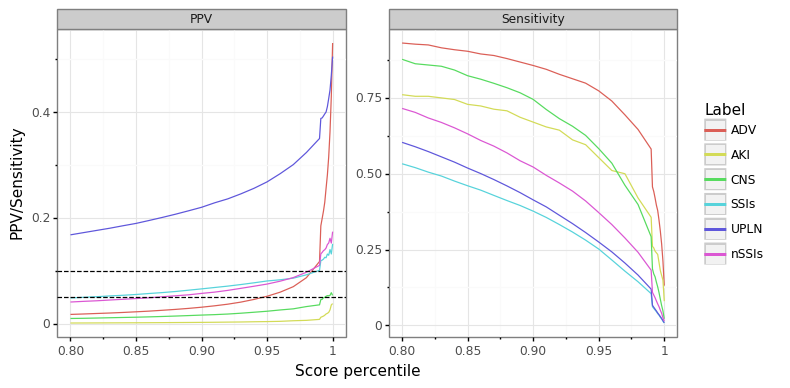

<ggplot: (2946228372751)>

In [13]:
w, h= 8, 4
plotnine.options.figure_size = (w, h)

tmp = pd.DataFrame({'yi':[0.05,0.10],'metric':'ppv'})

gg_ppv = (ggplot(res_ppv, aes(x='pp',y='value',color='outcome')) + 
          theme_bw() + geom_line() + 
          labs(x='Score percentile',y='PPV/Sensitivity') + 
          scale_color_discrete(name='Label') + 
          scale_x_continuous(breaks=list(np.arange(0.8,1.01,0.05))) + 
          facet_wrap('~metric',scales='free_y',labeller=labeller(metric={'ppv':'PPV','sens':'Sensitivity'})) + 
          theme(subplots_adjust={'wspace':0.15}) + 
         geom_hline(aes(yintercept='yi'),linetype='--',data=tmp))
gg_ppv


In [14]:
# res_ppv.query('outcome=="ADV"').pivot_table('value',['outcome','pp'],'metric').tail()

## (5) Figures

### (5.A) Variation between models/years

There is little variation between models in performance. Exception for a few kidney models in some years. Also shows that for any given model, there is very little variation between years. 

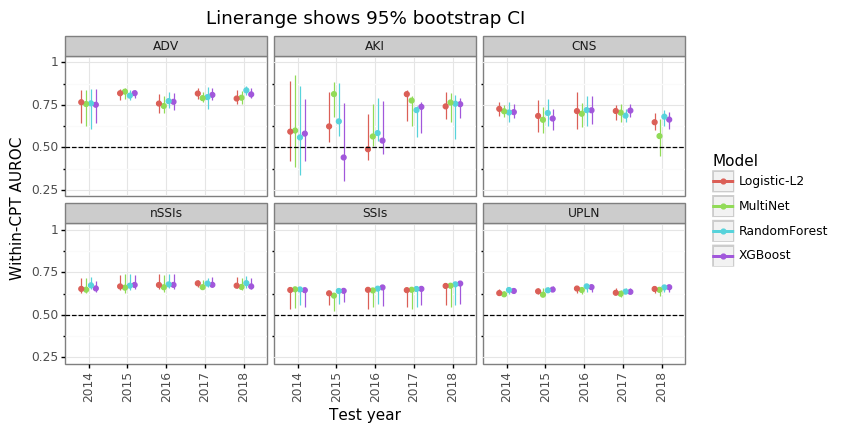

<ggplot: (-9223369090630292820)>

In [15]:
tmp = df_within_year_inf.query('tt=="within"').assign(model=lambda x: x.model.map(di_model)).copy()
posd = position_dodge(0.5)
w, h= 8, 4
plotnine.options.figure_size = (w, h)
gg_auc_within = (ggplot(tmp, aes(x='test_year.astype(str)',y='auc',color='model')) + 
                 theme_bw() + geom_point(position=posd) + 
                 geom_linerange(aes(ymin='lb',ymax='ub'),position=posd) + 
                 facet_wrap('~outcome',labeller=labeller(outcome=di_outcome)) + 
                 theme(axis_text_x=element_text(angle=90)) + #,axis_ticks_minor_y=element_blank()
                 labs(y='Within-CPT AUROC',x='Test year') + 
                 scale_y_continuous(limits=[0.25,1],breaks=list(np.arange(0.25,1.01,0.25))) + 
                 geom_hline(yintercept=0.5,linetype='--') + 
                 scale_color_discrete(name='Model') + 
                 ggtitle('Linerange shows 95% bootstrap CI'))
# gg_auc_within.save(os.path.join(dir_figures,'gg_auc_within.png'),base_height=h, base_width=w, verbose=False)
gg_auc_within

### (5.B) Variation between decomp/years

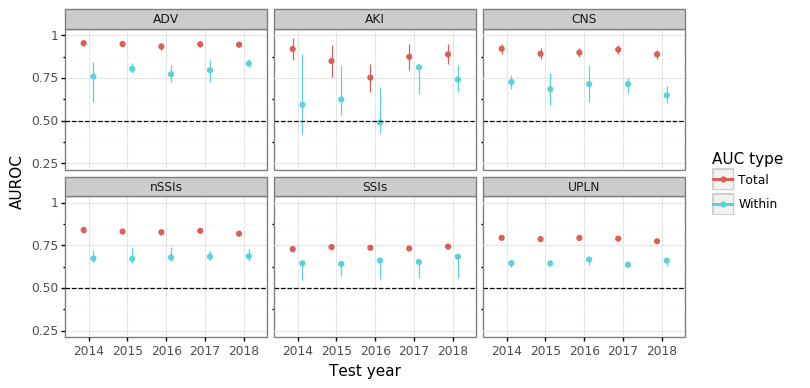

<ggplot: (-9223369090626111221)>

In [16]:
tmp = df_within_year_inf.merge(best_mdl)
w, h = 8, 4
posd = position_dodge(0.5)
plotnine.options.figure_size = (w, h)
gg_between = (ggplot(tmp,aes(x='test_year.astype(str)',y='auc',color='tt')) + 
              theme_bw() + geom_point(position=posd) + 
              facet_wrap('~outcome',labeller=labeller(outcome=di_outcome)) + 
              scale_color_discrete(name='AUC type',labels=['Total','Within']) + 
              geom_linerange(aes(ymin='lb',ymax='ub'),position=posd) + 
              labs(y='AUROC',x='Test year') + 
              geom_hline(yintercept=0.5,linetype='--') + 
              scale_y_continuous(limits=[0.25,1],breaks=list(np.arange(0.25,1.01,0.25))))
gg_between

In [17]:
# df_within_year_inf.merge(best_mdl).groupby(['tt']).auc.describe()
q1 = df_within_year_inf.merge(best_mdl).groupby(['tt','outcome']).auc.mean().reset_index().assign(auc=lambda x: x.auc-0.5).pivot('outcome','tt','auc')
q1.assign(dd=lambda x: x.total-x.within).assign(w_gain=lambda x: x.within/x.total)

tt,total,within,dd,w_gain
outcome,,,,
adv,0.446439,0.293201,0.153238,0.656755
aki,0.357015,0.152065,0.204950,0.425935
cns,0.403857,0.197485,0.206372,0.488998
nsi,0.330791,0.178884,0.151906,0.540778
ssi,0.236067,0.156935,0.079132,0.664790
unplan,0.288037,0.151173,0.136864,0.524839


### (5.C) Distribution within the "within"

/home/edrysdale/.local/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


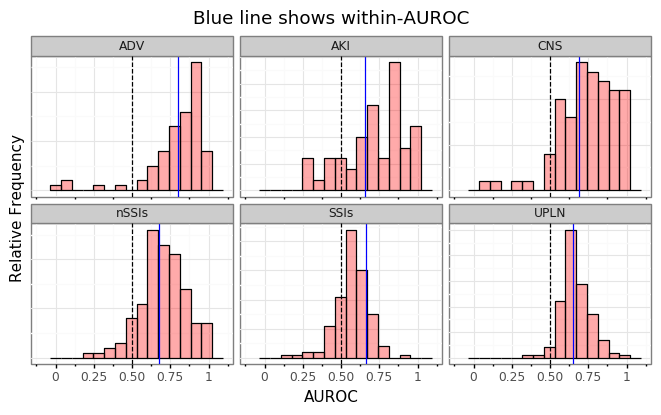

<ggplot: (-9223369090626754286)>

In [18]:
tmp1 = df_within.merge(best_mdl).query('tt=="within"').reset_index(None,True).copy()
tmp2 = df_within_cpt.merge(best_mdl).reset_index(None,True).copy()

w, h = 8, 4
plotnine.options.figure_size = (w, h)
gg_dist_cpt = (ggplot(tmp2, aes(x='auc')) + theme_bw() + 
              geom_histogram(bins=18,color='black',fill='red',alpha=1/3) + 
              facet_wrap('~outcome',scales='free_y',labeller=labeller(outcome=di_outcome)) + 
              labs(x='AUROC', y='Relative Frequency') + 
              scale_x_continuous(limits=[-0.1,1.1],breaks=list(np.arange(0,1.1,0.25))) + 
              theme(axis_text_y=element_blank(),axis_ticks_minor_y=element_blank(),
                    axis_ticks_major_y=element_blank()) + 
              geom_vline(aes(xintercept='auc'),data=tmp1,color='blue') + 
              ggtitle('Blue line shows within-AUROC') + 
              geom_vline(xintercept=0.5,linetype='--'))
gg_dist_cpt

In [19]:
tmp2.groupby('outcome').auc.mean().reset_index().merge(tmp1[['outcome','auc']],'left','outcome')

,outcome,auc_x,auc_y
0,adv,0.796361,0.801772
1,aki,0.720626,0.655228
2,cns,0.741926,0.687659
3,nsi,0.700112,0.678020
4,ssi,0.572226,0.659803
5,unplan,0.668071,0.651659


In [20]:
tmp2.groupby('outcome').apply(lambda x: pd.Series({'50':np.mean(x.auc > 0.5),'60':np.mean(x.auc > 0.6),
                                                  '70':np.mean(x.auc > 0.7),'80':np.mean(x.auc > 0.8)}))

,50,60,70,80
outcome,,,,
adv,0.939759,0.915663,0.819277,0.662651
aki,0.820000,0.760000,0.600000,0.440000
cns,0.919540,0.793103,0.632184,0.413793
nsi,0.903226,0.790323,0.491935,0.250000
ssi,0.833333,0.378788,0.098485,0.007576
unplan,0.985075,0.791045,0.313433,0.089552


### (5.D) CPT signficance

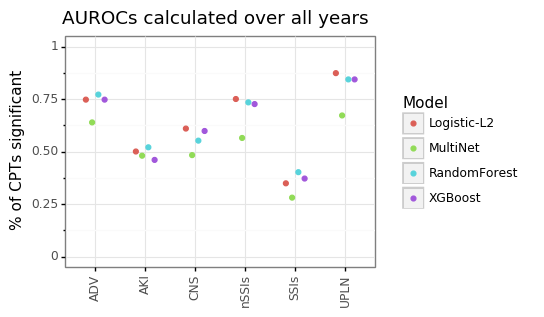

<ggplot: (-9223369090641507093)>

In [21]:
w, h= 4, 3
plotnine.options.figure_size = (w, h)
tmp = agg_cpt_sig.query('is_sig==True').assign(outcome=lambda x: 
       pd.Categorical(x.outcome,dat_cpt_sig.outcome.unique()).map(di_outcome),
      model=lambda x: x.model.map(di_model))

posd = position_dodge(0.5)
gg_sig = (ggplot(tmp,aes(x='outcome',y='pct',color='model')) + theme_bw() + 
          geom_point(position=posd) + 
         theme(axis_title_x=element_blank(),axis_text_x=element_text(angle=90)) + 
         scale_color_discrete(name='Model') + 
         labs(y='% of CPTs significant') + 
         ggtitle('AUROCs calculated over all years') + 
         scale_y_continuous(limits=[0,1]))
gg_sig

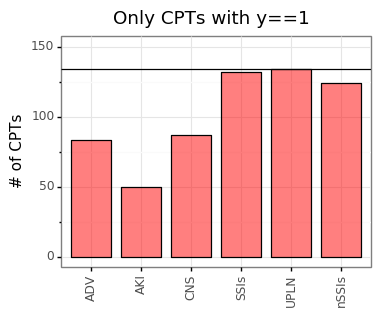

<ggplot: (-9223369090626085786)>

In [22]:
n_cpts_mdl = df_within_cpt.merge(best_mdl).groupby(['outcome']).size().reset_index().rename(columns={0:'tot'})
n_cpts_mdl.outcome = n_cpts_mdl.outcome.map(di_outcome)

w, h = 4, 3
plotnine.options.figure_size = (w, h)
gg_n_cpts_mdl = (ggplot(n_cpts_mdl,aes(x='outcome',y='tot')) + theme_bw() + 
                  geom_bar(stat='identity',color='black',fill='red',alpha=0.5,width=0.8) + 
                 theme(axis_title_x=element_blank(),axis_text_x=element_text(angle=90)) + 
                 labs(y='# of CPTs') + 
                 scale_y_continuous(limits=[0,150]) + 
                 ggtitle('Only CPTs with y==1') + 
                geom_hline(yintercept=134))
gg_n_cpts_mdl

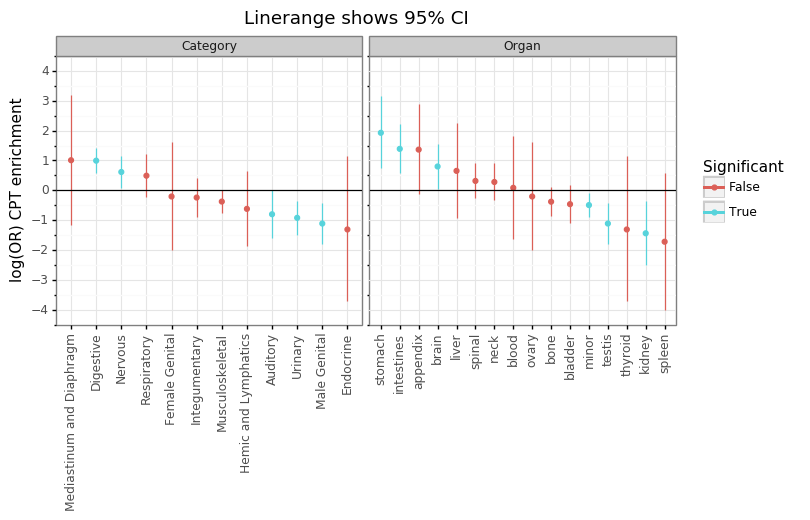

<ggplot: (-9223369090639618872)>

In [23]:
w, h= 8, 3.5
plotnine.options.figure_size = (w, h)
gg_sig = (ggplot(sig_both,aes(x='term',y='lOR',color='pval<0.05')) + theme_bw() + 
          geom_point() + geom_linerange(aes(ymin='lOR-1.96*se',ymax='lOR+2*se')) + 
          facet_wrap('~tt',scales='free_x',labeller=labeller(tt={'group':'Category','organ':'Organ'})) + 
         theme(axis_title_x=element_blank(),axis_text_x=element_text(angle=90)) + 
         geom_hline(yintercept=0) + 
         scale_y_continuous(limits=[-4.1,4.1],breaks=list(np.arange(-4,4.1,1))) + 
         labs(y='log(OR) CPT enrichment') + 
         ggtitle('Linerange shows 95% CI') + 
         scale_color_discrete(name='Significant'))
gg_sig